# UQ : Bagging on sparse dataset

In [1]:
import joblib
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import TransformedTargetRegressor

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import clone_model

from sklearn.metrics import mean_squared_error, mean_absolute_error

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
pd.set_option('display.max_columns', 500)

2022-08-25 11:14:55.946748: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-25 11:14:55.953473: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-25 11:14:55.953491: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from goat3.pipeline import PandasPipeline, ColumnsSelector
from goat3.validation import plot_adequation, plot_residuals, plot_confidence, plot_confidence_v2, plot_cumulative
from goat3.metamodel import KerasRegressorGoat, BaggingRegressorGoat
from goat3 import create_fully_connected
from goat3.validation._validation import table_results

## Load Data

In [3]:
#load data
data = pd.read_pickle('../../../Data/Sparse_data.pkl')

In [6]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,y
0,0.569733,0.577586,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.365751,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.175117,0.643701,0.0,0.200465,0.0,0.0,0.153066,0.0,0.119772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.276289,0.224762,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.769745,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.652105,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.004069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.145559,0.073487,0.066852,0.0,0.0,0.0,0.0,0.

In [4]:
# Split data traning and target.
y = data['y']
X = data.drop(["y"], axis=1)

In [5]:
#Split data into training and testing sets
test_size = 0.1
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size)

# data shapes summary
print(f"\nTraining Data : {X_train.shape}")
print(f"Testing Data  : {X_test.shape}\n")


Training Data : (8817, 753)
Testing Data  : (980, 753)



## Model

In [6]:
def get_base_model(units=1):
    model = Sequential()
    model.add(Dense(100, activation="relu"))
    model.add(Dense(100, activation="relu"))
    model.add(Dense(100, activation="relu"))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(units, activation=None))
    model.compile(loss="mse", optimizer=Adam(0.001))
    return model

## Methods

### Boostrap

In [7]:
network = KerasRegressorGoat(get_base_model,
                             epochs=50,
                             verbose=0,
                             batch_size=128)

regressor = TransformedTargetRegressor(
    regressor=network)

bagging = BaggingRegressorGoat(regressor, n_estimators=30, verbose=0, n_jobs=10, bootstrap=True)

model = PandasPipeline([("model", bagging)])

In [8]:
model.fit(X_train, y_train);

2022-08-22 10:13:53.493431: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-22 10:13:53.493432: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-22 10:13:53.493431: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-22 10:13:53.498987: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic lib

In [9]:
y_train_pred, y_train_q05, y_train_q95 = model.predict(X_train, aggregation=["median", "q05", "q95"], n_jobs=1)
y_test_pred, y_test_q05, y_test_q95 = model.predict(X_test, aggregation=["median", "q05", "q95"], n_jobs=1)

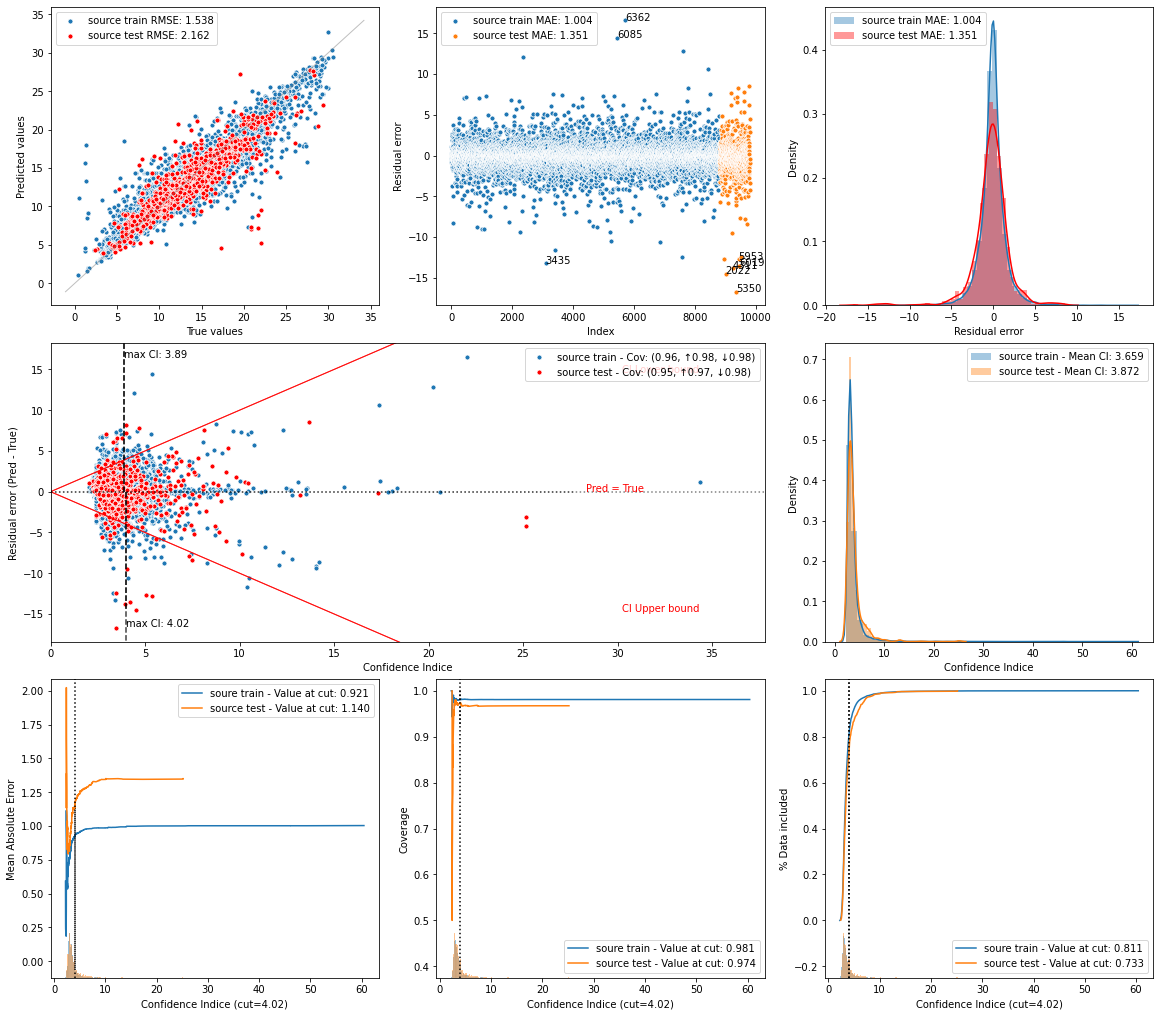

In [10]:
warnings.simplefilter(action='ignore', category=FutureWarning)

fig = plt.figure(constrained_layout=True, figsize=(16, 14))
gs = fig.add_gridspec(3, 3)

ax1 = fig.add_subplot(gs[0, 0]); ax2 = fig.add_subplot(gs[0, 1]); ax3 = fig.add_subplot(gs[0, 2]);
ax4 = fig.add_subplot(gs[1, 0:2]); ax5 = fig.add_subplot(gs[1, 2]);
ax6 = fig.add_subplot(gs[2, 0]); ax7 = fig.add_subplot(gs[2, 1]); ax8 = fig.add_subplot(gs[2, 2]);

plot_adequation(y_train, y_train_pred, label='source train', ax=ax1, score='RMSE')
plot_adequation(y_test, y_test_pred, label='source test', ax=ax1,color='red', plot_line=False, score='RMSE')

plot_residuals(y_train, y_train_pred, label='source train',ax=ax2,score='MAE',show_outliers=3)
plot_residuals(y_test, y_test_pred, index=len(y_train), label='source test', ax=ax2,score='MAE',show_outliers=5)

plot_residuals(y_train, y_train_pred, kind='hist', label='source train', ax=ax3, score='MAE')
plot_residuals(y_test, y_test_pred, kind='hist', label='source test', color='red', ax=ax3, score='MAE')

cut = model[-1].thresholds_

plot_confidence_v2(y_train, y_train_pred, y_train_q05, y_train_q95, label='source train', ax=ax4, cut=cut)
plot_confidence_v2(y_test, y_test_pred, y_test_q05, y_test_q95, label='source test',color='red', ax=ax4, cut=cut)

plot_residuals( y_train_pred, y_train_q95, kind='hist', label='source train - Mean CI:', score=mean_absolute_error, ax=ax5)
plot_residuals(y_test_pred, y_test_q95, kind='hist', label='source test - Mean CI:', ax=ax5, score=mean_absolute_error)
ax5.set_xlabel("Confidence Indice")

plot_cumulative((y_train_q95-y_train_pred), np.abs(y_train-y_train_pred), name="Mean Absolute Error", cut=cut[-1], label="soure train", ax=ax6)
plot_cumulative((y_test_q95-y_test_pred), np.abs(y_test-y_test_pred), ax=ax6, name="Mean Absolute Error", cut=cut[-1], label="source test")

plot_cumulative((y_train_q95-y_train_pred), (y_train<=y_train_q95), name="Coverage", cut=cut[-1], label="soure train", ax=ax7)
plot_cumulative((y_test_q95-y_test_pred), (y_test<=y_test_q95), ax=ax7, name="Coverage", cut=cut[-1], label="source test")

plot_cumulative((y_train_q95-y_train_pred), np.ones(len(y_train_q95)), name="% Data included", normalize=False, cut=cut[-1], label="soure train", ax=ax8)
plot_cumulative((y_test_q95-y_test_pred), np.ones(len(y_test_q95)), name="% Data included", normalize=False, cut=cut[-1], label="source test", ax=ax8)

plt.show()

### Table

<AxesSubplot:xlabel='Confidence Indice', ylabel='Residual error (Pred - True)'>

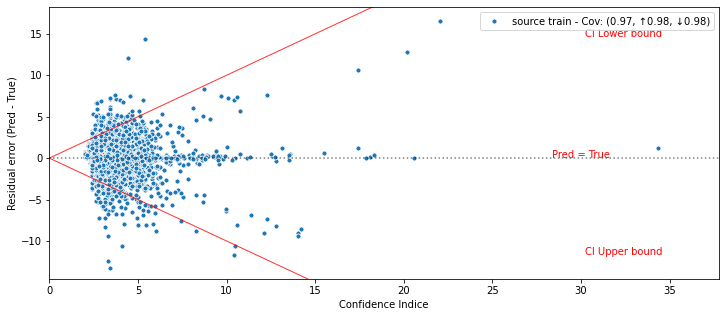

In [11]:
plot_confidence_v2(y_train, y_train_pred, y_train_q05, y_train_q95, label='source train')

<AxesSubplot:xlabel='Confidence Indice', ylabel='Residual error (Pred - True)'>

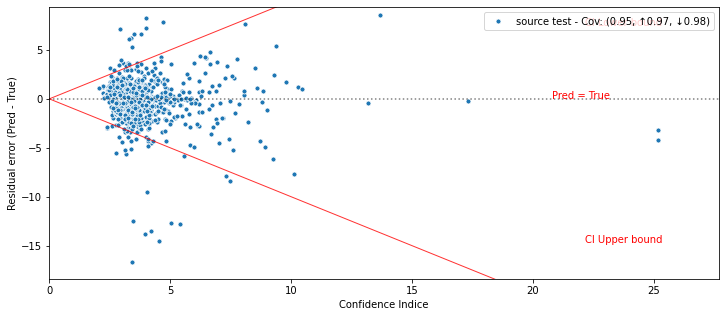

In [12]:
plot_confidence_v2(y_test, y_test_pred, y_test_q05, y_test_q95, label='source test')

In [20]:
table_results(y_test, y_test_pred, [y_test_q05, y_test_q95], thresholds=model[-1].thresholds_, show_both=True)

,Mean Residual,Coverage,Mean Confidence Indice,Threshold,% Data Below Threshold
Down,1.388359,0.975749,3.265820,4.129285,0.715306
Up,1.388359,0.966521,3.130112,3.937235,0.701020
Both,1.051372,0.941667,3.148759,NaN,0.612245


In [13]:
y_test_pred, stds_test = model.predict(X_test, aggregation=["median", "std"], n_jobs=1)

In [14]:
import uncertainty_toolbox as uct

In [15]:
pnn_metrics = uct.metrics.get_all_metrics(np.array(y_test_pred), np.array(stds_test), np.array(y_test))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  7.23it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  7.28it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           1.351
  RMSE          2.162
  MDAE          0.863
  MARPD         10.378
  R2            0.753
  Correlation   0.869
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.175
  Mean-absolute Calibration Error       0.155
  Miscalibration Area                   0.156
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.201
     Group Size: 0.56 -- Calibration Error: 0.171
     Group Size: 1.00 -- Calibration Error: 0.155
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.231
     Group Size: 0.56 -- Calibration Error: 0.191
     Group Size: 1.00 -- Calibration Error: 0.175
===============

<AxesSubplot:title={'center':'Average Calibration'}, xlabel='Predicted Proportion in Interval', ylabel='Observed Proportion in Interval'>

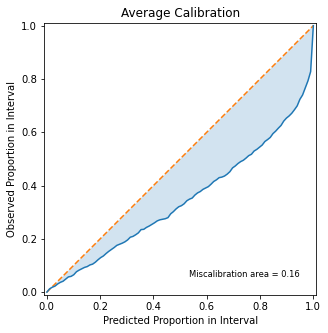

In [16]:
uct.viz.plot_calibration(np.array(y_test_pred),  np.array(stds_test) , np.array(y_test))

In [17]:
# Fit a Calibrator using the standard deviations.
recalibrator = uct.recalibration.get_std_recalibrator(np.array(y_test_pred), np.array(stds_test), np.array(y_test), criterion='ma_cal')
new_stds = recalibrator(np.array(stds_test))

<AxesSubplot:title={'center':'Average Calibration'}, xlabel='Predicted Proportion in Interval', ylabel='Observed Proportion in Interval'>

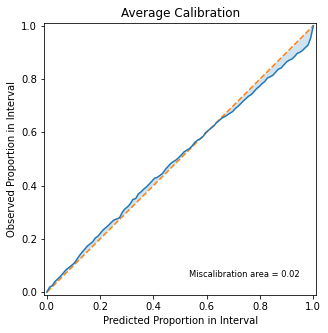

In [18]:
uct.viz.plot_calibration(np.array(y_test_pred),  np.array(new_stds) , np.array(y_test))

<AxesSubplot:xlabel='Confidence Indice', ylabel='Residual error (Pred - True)'>

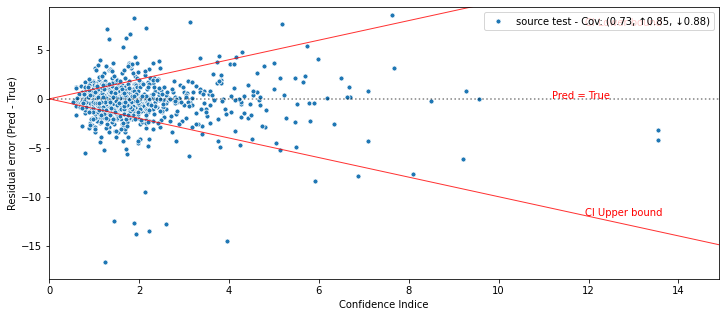

In [19]:
plot_confidence_v2(y_test, y_test_pred , y_test_pred-2*stds_test,  y_test_pred+2*stds_test, label='source test')

<AxesSubplot:xlabel='Confidence Indice', ylabel='Residual error (Pred - True)'>

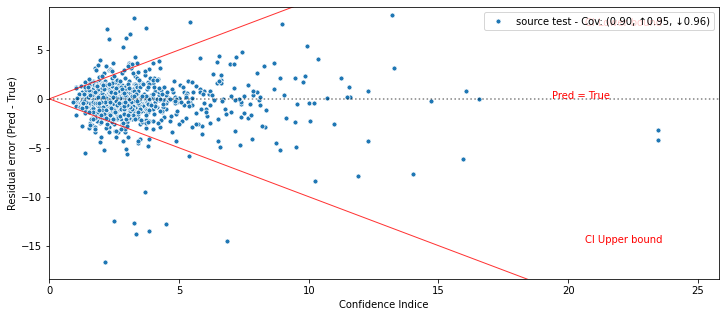

In [20]:
plot_confidence_v2(y_test, y_test_pred , y_test_pred-2*new_stds,  y_test_pred+2*new_stds, label='source test')

In [21]:
all_metrics_calib = uct.metrics.get_all_metrics(np.array(y_test_pred), np.array(new_stds), np.array(y_test))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  7.09it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  7.07it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           1.351
  RMSE          2.162
  MDAE          0.863
  MARPD         10.378
  R2            0.753
  Correlation   0.869
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.022
  Mean-absolute Calibration Error       0.019
  Miscalibration Area                   0.019
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.057
     Group Size: 0.56 -- Calibration Error: 0.028
     Group Size: 1.00 -- Calibration Error: 0.019
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.065
     Group Size: 0.56 -- Calibration Error: 0.031
     Group Size: 1.00 -- Calibration Error: 0.022
===============

### Save metrics

In [23]:
import pickle

In [24]:
with open('Bagging_metrics_sparse.pkl', 'wb') as f:
    pickle.dump(all_metrics_calib, f)